In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] : 20
import nlopt
import time
from scipy.stats import lognorm, norm, chi2, uniform
from scipy.interpolate import UnivariateSpline
import matplotlib.gridspec as gridspec

In [2]:
a = np.zeros(3)  # a=zeros(3)
J = 1.0; D = 1.0; k = 1/10.0;  # Define parameters
α = J/np.sqrt(D*k); β = np.sqrt(k/D); σ = 1.0/2;  # Define rescaled parameters
x = np.linspace(0, 20, 21)  # Set up discretisation of truncated domain 0 < x < 20, with uniform mesh spacing of 1.0
xx = np.linspace(0, 20, 201)  # Set up fine discretisation of truncated domain 0 < x < 20, with uniform mesh spacing of 0.1

In [3]:
def model(x, a):
    # Return the BVP solution at positions in the vector x
    return a[0] * np.exp(-x * a[1])    

## Morphogen gradient model

### Reaction-diffusion equation for density $u(x,t) \ge 0$,

\begin{equation*}
\large{\dfrac{\partial u}{\partial t} =  D \dfrac{\partial^2 u}{\partial x^2} - k u,} \quad \textrm{on} \quad \large{x > 0.} 
\end{equation*}

### Initial condition

\begin{equation*}
\large{u(x,0)=0} \quad \textrm{on} \quad \large{x > 0.}
\end{equation*}

### Boundary conditions

\begin{align*}
\large{J} &\large{=-D \dfrac{\partial u}{\partial x}} \quad \textrm{at} \quad \large{x=0}, \notag \\
\large{u(x,t)} &\large{= 0,} \quad \textrm{as} \quad \large{x \to \infty}. \notag \\
\end{align*}

## Morphogen gradient model

### Long-time BVP $t \to \infty$

\begin{equation*}
\large{D\dfrac{\textrm{d}^2 U}{\textrm{d}x^2}-kU=0}, \quad \textrm{on} \quad \large{x > 0}.
\end{equation*}

### Boundary conditions

\begin{align*}
\large{J} &\large{=-D\dfrac{\textrm{d} U}{\textrm{d}x}} \quad \textrm{at} \quad \large{x=0}, \notag \\
\large{U} &\large{= 0,} \quad \textrm{as} \quad \large{x \to \infty.} \notag \\
\end{align*}

### Exact solution with re-scaled parameters

\begin{equation*}
\large{U = \alpha \textrm{exp}\left(-\beta x \right)}.
\end{equation*}

### Parameters

\begin{equation*}
\large{\theta = \left(\alpha, \beta \right)^\top = \left(\dfrac{J}{\sqrt{kD}},  \sqrt{\dfrac{k}{D}}\right)^\top }.
\end{equation*}

In [4]:
# Fixed data generated by solving the process model and corrupting the solution with multiplicative log-normal noise with sigma=0.5 
data = np.array([ 3.898952675812746,  
2.569825438525737,  
1.206631819080483,  
1.3543817108830818, 
0.6175527058221386, 
0.30785528929186456,
0.13649714414672498,
0.6921031114954066, 
0.271392505145547,  
0.0945662375934022, 
0.06039757137011752,
0.1338145218277993, 
0.1529291485263356,
0.05189445084962129,
0.02756210195622014,
0.018066943988933968,
0.017710583152626524,
0.009164129234587067,
0.008075081582671598,
0.010557776318846062,
0.004853780605374777])

## Noise model: Log-Normal 


\begin{equation*}
\large{U^{\textrm{obs}}(x_i) \mid \theta = \left[U(x_i) \mid \theta\right]\eta_i,} \quad \large{\eta_i \sim \textrm{log-normal} (0,\sigma^2).}
\end{equation*}


## Log-likelihood function

\begin{equation*}
	\large{\ell(\theta \mid U^\textrm{obs}(x_i)) = \sum_{i=1}^{I} \log \left[\phi\left(U^\textrm{obs}(x_i); \log(U(x_i)), \sigma^2 \right)\right]}.
\end{equation*}

In [5]:
def loglhood(data, a, sigma):
    # Evaluate the model solution with parameters a = [α, β]
    y = model(x, a)  # Assuming model(x, a) returns a numpy array
    # Ensure valid values (avoid zero division)
    valid_mask = (y > 0) & (data > 0)
    if not np.any(valid_mask):
        return -np.inf  # If no valid data points, return negative infinity log-likelihood
    # Compute the ratio where both data and model values are valid
    ratio = data[valid_mask] / y[valid_mask]
    # Compute log-likelihood using LogNormal PDF, with s=sigma and scale=1 (mean=0)
    log_likelihoods = lognorm.logpdf(ratio, sigma, scale=1)
    # Sum up all the log-likelihood values
    return np.sum(log_likelihoods)

In [6]:
a = np.zeros(2)
def funmle(a):
    return loglhood(data, a, σ)  # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters  a = [α, β]

In [7]:
def Optimise(fun, θ0, lb, ub):
    # Optimize finds the values of parameters θ that maximise the objective function fun with lower bounds lb, and upper bounds ub
    def tomax(θ, grad):
        return fun(θ)
    dim = len(θ0)
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, dim)
    opt.set_max_objective(tomax)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_maxtime(60)  # 1*60 seconds
    xopt = opt.optimize(np.array(θ0))
    fopt = opt.last_optimum_value()
    return (xopt, fopt)

In [8]:
θG = [α, β]  # Initial parameter estimates for the iterative optimization solver 
lb = [0, 0]  # lower bounds
ub = [1000, 1000]  # upper bounds
start_time = time.time()
(xopt, fopt) = Optimise(funmle, θG, lb, ub)  # Compute MLE and value of the log-likelihood at the MLE, print the time taken to optimize the solution
print("Time taken for optimization:", time.time() - start_time)
αmle = xopt[0]  # Store MLE for α
βmle = xopt[1]  # Store MLE for β
fmle = fopt     # Store log-likelihood value at the MLE
def cmle(x_val):
    return αmle * np.exp(-x_val * βmle)  # MLE solution

Time taken for optimization: 0.03850412368774414


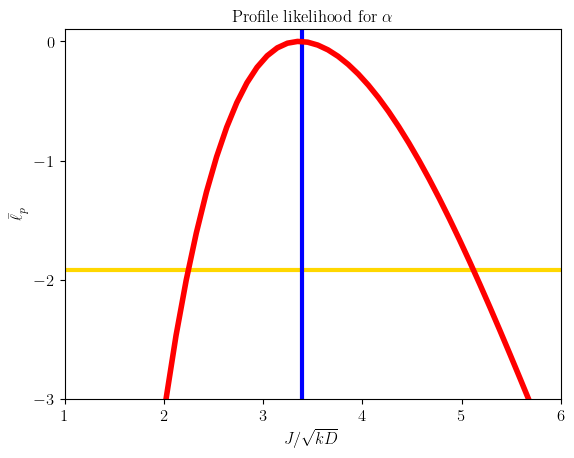

In [9]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

def univariateα(α_val):
    # Function to compute the univariate profile likelihood for α
    a_temp = np.zeros(1)    
    def funα(a_param):
        return loglhood(data, [α_val, a_param[0]], σ)  # evaluate the log-likelihood at a specified value of α
    θG_local = [βmle]  # Estimate of the nuisance parameter β
    lb_local = [0.0]  # lower bound of the nuisance parameter β
    ub_local = [1000.0]  # upper bound of the nuisance parameter β
    (xopt_local, fopt_local) = Optimise(funα, θG_local, lb_local, ub_local)
    return (fopt_local, xopt_local)  # Return the profile log-likelihood and value of the nuisance parameter

def f_alpha(x_val):
    return univariateα(x_val)[0]  # Define function to compute the profile likelihood 

M = 50  # Take a grid of M points to plot the univariate profile likelihood
αrange = np.linspace(1, 6, M)
ff = np.zeros(M)
for i in range(M):
    ff[i] = univariateα(αrange[i])[0]  # Compute the profile log-likelihood over the M mesh points

plt.figure()
# Plot the normalised profile log-likelihood for α, superimposed with the MLE and 95% threshold
plt.axhline(y=llstar, color="gold", linewidth=3, label=False)
plt.axvline(x=αmle, color="blue", linewidth=3)
spl = UnivariateSpline(αrange, ff - np.max(ff), w=np.ones(len(αrange)), k=3)
spl.set_smoothing_factor(1/100)
yy = spl(αrange)
plt.plot(αrange, yy, linewidth=4, color="red")
plt.ylim(-3, 0.1)
plt.xlim(αrange[0], αrange[-1])
plt.xticks([1, 2, 3, 4, 5, 6], [r"$1$", r"$2$", r"$3$", r"$4$", r"$5$", r"$6$"],fontsize=12)
plt.yticks([0, -1, -2, -3], [r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12)
plt.xlabel(r"$J/\sqrt{kD}$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.title(r"$\textrm{Profile likelihood for } \alpha$",fontsize=12)
q1_fig = plt.gcf()
plt.show()

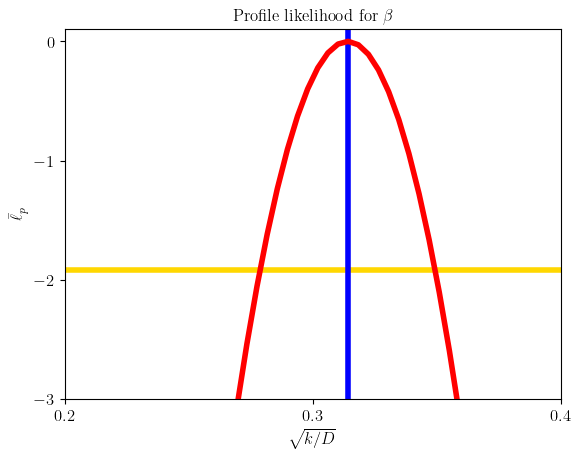

In [10]:
def univariateβ(β_val):
    # Function to compute the univariate profile likelihood for β
    a_temp = np.zeros(1)    
    def funβ(a_param):
        return loglhood(data, [a_param[0], β_val], σ)  # evaluate the log-likelihood at a specified value of β
    θG_local = [αmle]  # Estimate of the nuisance parameter α
    lb_local = [0.0]  # lower bound of the nuisance parameter α
    ub_local = [1000.0]  # upper bound of the nuisance parameter α
    (xopt_local, fopt_local) = Optimise(funβ, θG_local, lb_local, ub_local)
    return (fopt_local, xopt_local)

def f_beta(x_val):
    return univariateβ(x_val)[0]

M = 50  # Take a grid of M points to plot the univariate profile likelihood
βrange = np.linspace(0.2, 0.4, M)
ff_beta = np.zeros(M)
for i in range(M):
    ff_beta[i] = univariateβ(βrange[i])[0]  # Compute the profile log-likelihood over the M mesh points

plt.figure()
# Plot the normalised profile log-likelihood for β, superimposed with the MLE and 95% threshold
plt.axhline(y=llstar, color="gold", linewidth=4, label=False)
plt.axvline(x=βmle, color="blue", linewidth=4)
spl_beta = UnivariateSpline(βrange, ff_beta - np.max(ff_beta), w=np.ones(len(βrange)), k=3)
spl_beta.set_smoothing_factor(1/100)
yy_beta = spl_beta(βrange)
plt.plot(βrange, yy_beta, linewidth=4, color="red")
plt.ylim(-3, 0.1)
plt.xlim(βrange[0], βrange[-1])
plt.xticks([0.2, 0.3, 0.4], [r"$0.2$", r"$0.3$", r"$0.4$"],fontsize=12)
plt.yticks([0, -1, -2, -3], [r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12)
plt.xlabel(r"$\sqrt{k/D}$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.title(r"$\textrm{Profile likelihood for } \beta$",fontsize=12)
q2_fig = plt.gcf()
plt.show()

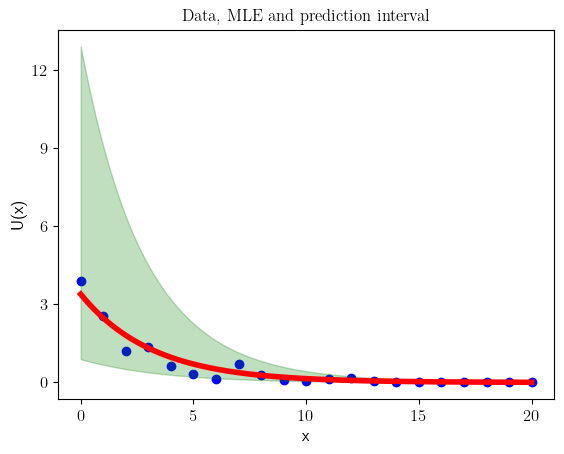

In [13]:
αmin = 1; αmax = 8;
βmin = 0.2; βmax = 0.4;  # Define simple bounds on each parameter space

df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

M_samples = 1000  # Number of samples to be drawn
αsampled = np.zeros(M_samples)
βsampled = np.zeros(M_samples)
lls = np.zeros(M_samples)
kount = 0  # global counter

while kount < M_samples:
    αg = np.random.uniform(αmin, αmax)  # Draw a random sample of α 
    βg = np.random.uniform(βmin, βmax)  # Draw a random sample of β
    loglikelihood=loglhood(data, [αg, βg], σ) - fmle
    if loglikelihood >= llstar:  # keep the sample if it lies within the 95% threshold
        kount += 1
        lls[kount-1] = loglikelihood
        αsampled[kount-1] = αg
        βsampled[kount-1] = βg

lower = 10 * np.ones(len(xx))  # Define vector on the fine spatial discretisation that will store the lower limit of the prediction interval
upper = np.zeros(len(xx))        # Define vector on the fine spatial discretisation that will store the upper limit of the prediction interval

# Precompute quantiles for Normal(0,σ)
q_lower = norm.ppf(0.05, loc=0, scale=σ)
q_upper = norm.ppf(0.95, loc=0, scale=σ)

for i in range(M_samples):
    def c(x_val):
        return αsampled[i] * np.exp(-x_val * βsampled[i])   # For each parameter sample solve the process model
    for j in range(len(xx)):
        val = c(xx[j])
        if val * np.exp(q_lower) < lower[j]:  # For each location across the domain compute the lower bound of the noise model
            lower[j] = val * np.exp(q_lower)  # For each location across the domain store the lower bound
        if val * np.exp(q_upper) > upper[j]:  # For each location across the domain compute the upper bound of the noise model
            upper[j] = val * np.exp(q_upper)  # For each location across the domain store the upper bound

plt.figure()
# Plot the data
plt.scatter(x, data, color="blue", label=False)
# Plot the MLE solution
plt.plot(xx, cmle(xx), color="red", linewidth=4, label=False)
plt.xlim(xx[0]-1, xx[-1]+1)
plt.xlabel("x",fontsize=12)
plt.ylabel("U(x)",fontsize=12)
plt.xticks([0, 5, 10, 15, 20], [r"$0$", r"$5$", r"$10$", r"$15$", r"$20$"],fontsize=12)
plt.yticks([0, 3, 6, 9, 12], [r"$0$", r"$3$", r"$6$", r"$9$", r"$12$"],fontsize=12)
plt.gca().tick_params(labelsize=12)
# Plot the prediction interval
plt.fill_between(xx, lower, upper, color="green", alpha=0.25, label=False)
p1_fig = plt.gcf()
plt.title(r"$\textrm{Data, MLE and prediction interval}$",fontsize=12)
plt.show()  # Figure 7(a)


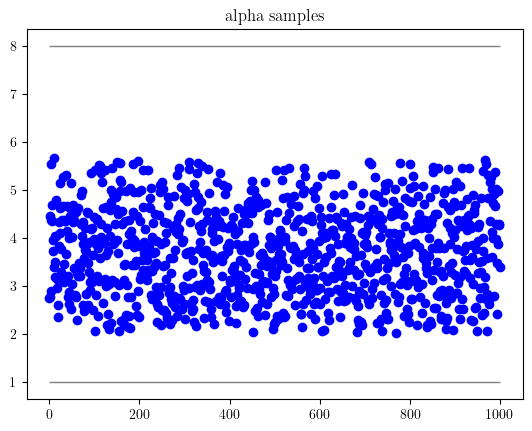

In [21]:
plt.figure()
# Plot the alpha samples
plt.scatter(range(M_samples), αsampled, color="blue", label=False)
plt.hlines([αmin,αmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
plt.title(r"$\textrm{alpha samples}$",fontsize=12)
plt.show()

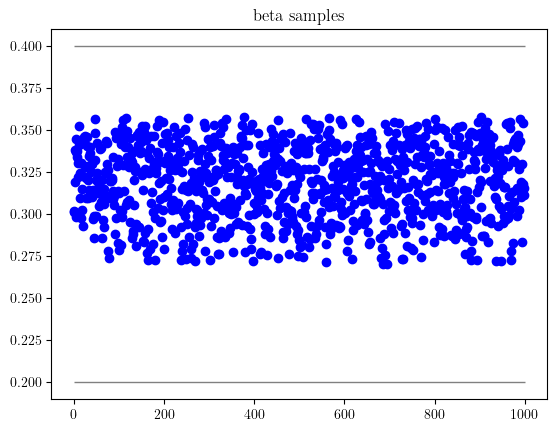

In [23]:
plt.figure()
# Plot the beta samples
plt.scatter(range(M_samples), βsampled, color="blue", label=False)
plt.hlines([βmin,βmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
plt.title(r"$\textrm{beta samples}$",fontsize=12)
plt.show()